<a href="https://colab.research.google.com/github/umersajid11/CatDogClassification/blob/main/FineTuningVG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 98% 1.04G/1.06G [00:09<00:00, 192MB/s]
100% 1.06G/1.06G [00:10<00:00, 114MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import os, shutil
from sklearn.model_selection import train_test_split

# Define source folders
base_dir = "/content/train"
cat_dir = os.path.join(base_dir, "cats")
dog_dir = os.path.join(base_dir, "dogs")

# Get image file names
cat_images = [f for f in os.listdir(cat_dir) if f.endswith('.jpg')]
dog_images = [f for f in os.listdir(dog_dir) if f.endswith('.jpg')]

# Split into train and val (90% train, 10% val)
cat_train, cat_val = train_test_split(cat_images, test_size=0.1, random_state=42)
dog_train, dog_val = train_test_split(dog_images, test_size=0.1, random_state=42)

# Create new folder structure
def make_dirs(base_path):
    for subset in ['train', 'val']:
        for label in ['cats', 'dogs']:
            path = os.path.join(base_path, subset, label)
            os.makedirs(path, exist_ok=True)

make_dirs('/content/data')

# Function to move images
def move_images(images, src_folder, dst_folder):
    for img in images:
        src = os.path.join(src_folder, img)
        dst = os.path.join(dst_folder, img)
        shutil.copyfile(src, dst)

# Move cat images
move_images(cat_train, cat_dir, '/content/data/train/cats')
move_images(cat_val, cat_dir, '/content/data/val/cats')

# Move dog images
move_images(dog_train, dog_dir, '/content/data/train/dogs')
move_images(dog_val, dog_dir, '/content/data/val/dogs')

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
# Data Augmentation and Preprocessing
image_size = (227, 227)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.15,
    width_shift_range=0.1,
    fill_mode='nearest'
)

In [8]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
#Generator
train_generator = train_datagen.flow_from_directory(
    '/content/data/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # Since it's binary classification: cat vs dog
)

val_generator = val_datagen.flow_from_directory(
    '/content/data/val',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [16]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D # Import GlobalAveragePooling2D
from tensorflow.keras.models import Model # Import Model
from tensorflow.keras.callbacks import ModelCheckpoint # Import ModelCheckpoint

In [13]:
# Load VGG16 base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(227, 227, 3))

In [14]:
# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

In [17]:
# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

base_model is the pre-trained VGG16 model without its top dense layers (i.e., include_top=False).

base_model.output gives you the last convolutional feature map (shape: (7, 7, 512) for 224×224 images).

Applies Global Average Pooling to convert the 3D feature map (7, 7, 512) into a 1D vector of shape (512,).

It reduces overfitting and has fewer parameters than Flatten() (commonly used in transfer learning).

Benefit: More robust and generalizes better.

✅ What this does:
model = Model(inputs=base_model.input, outputs=output)

Creates the full transfer learning model, combining:

Input of VGG16

VGG16 convolutional base

Your custom top layers (GAP → Dense → Dropout → Output)

This model is now ready for fine-tuning after freezing/unfreezing layers and compiling.

In [19]:
# === Step 4: Compile for feature extraction phase ===
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# === Step 5: Train the top classifier head ===
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

Epoch 1/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 283s 496ms/step - accuracy: 0.8433 - loss: 0.3194 - val_accuracy: 0.9675 - val_loss: 0.1022
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 267s 474ms/step - accuracy: 0.9531 - loss: 0.1189 - val_accuracy: 0.9690 - val_loss: 0.0950
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 265s 470ms/step - accuracy: 0.9621 - loss: 0.0995 - val_accuracy: 0.9705 - val_loss: 0.0819
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 275s 489ms/step - accuracy: 0.9683 - loss: 0.0789 - val_accuracy: 0.9700 - val_loss: 0.0840
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 268s 475ms/step - accuracy: 0.9753 - loss: 0.0629 - val_accuracy: 0.9745 - val_loss: 0.0733


In [18]:
# === Step 6: Unfreeze some VGG layers for fine-tuning ===
for layer in base_model.layers[-4:]:  # Unfreeze last 4 VGG layers
    layer.trainable = True

# Compile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# === Step 7: Fine-tune the full model ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint('vgg16_finetuned.h5', save_best_only=True)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


KeyboardInterrupt: 

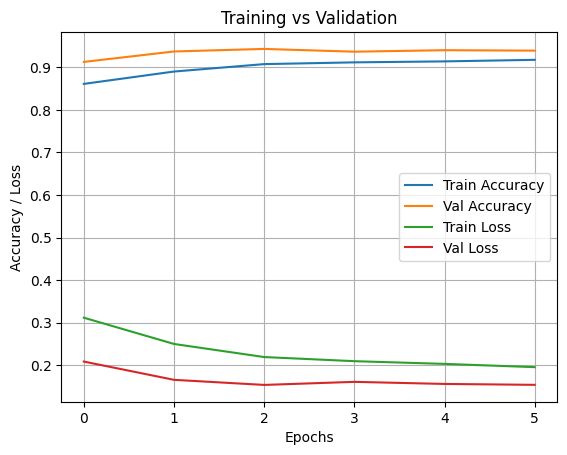

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy / Loss")
plt.grid(True)
plt.show()
